In [13]:
from google.colab import drive
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout , BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
class LSTMCell(Layer):
    def __init__(self, units, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units * 4),
                                  initializer="glorot_uniform",
                                  name="Wx")
        self.Wh = self.add_weight(shape=(self.units, self.units * 4),
                                  initializer="glorot_uniform",
                                  name="Wh")
        self.bias = self.add_weight(shape=(self.units * 4,),
                                     initializer="zeros",
                                     name="bias")
        self.built = True

    def call(self, inputs, states):
        h_tm1, c_tm1 = states

        z = tf.matmul(inputs, self.Wx) + tf.matmul(h_tm1, self.Wh) + self.bias
        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        i = tf.sigmoid(z0)  # input gate
        f = tf.sigmoid(z1)  # forget gate
        o = tf.sigmoid(z3)  # output gate
        g = tf.tanh(z2)     # candidate

        c_t = f * c_tm1 + i * g
        h_t = o * tf.tanh(c_t)

        return h_t, [h_t, c_t]

In [7]:
class LSTM(Layer):
    def __init__(self, units, return_sequences=False, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = LSTMCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))

        outputs = []
        for t in range(time_steps):
            h, [h, c] = self.cell(inputs[:, t, :], [h, c])
            if self.return_sequences:
                outputs.append(h)

        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        else:
            return h

In [8]:
df = pd.read_csv("/content/drive/MyDrive/NN_Data/train.csv")
df = df.iloc[:, 1:]

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    text = "".join([char for char in text if char.isalpha() or char.isspace()])


    tokens = word_tokenize(text.lower())

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['Discussion'] = df['Discussion'].apply(preprocess_text)
df = df.dropna()

In [9]:
category_mapping = {'Politics': 0, 'Sports': 1, 'Media': 2, 'Market & Economy': 3, 'STEM': 4}
df['Category'] = df['Category'].map(category_mapping)

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Discussion']).toarray()

y = np.array(df['Category'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [14]:
model_lstm = tf.keras.Sequential([

    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=64,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f'Bidirectional LSTM Test Accuracy: {test_accuracy * 100:.2f}%')

model_lstm.save('tfidf_lstm_model.h5')

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5035 - loss: 1.2538 - val_accuracy: 0.6080 - val_loss: 1.2033
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7435 - loss: 0.7041 - val_accuracy: 0.6513 - val_loss: 0.8891
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7810 - loss: 0.5893 - val_accuracy: 0.6441 - val_loss: 0.9888
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7995 - loss: 0.5178 - val_accuracy: 0.6377 - val_loss: 1.1112
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8168 - loss: 0.4638 - val_accuracy: 0.6283 - val_loss: 1.2048
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8257 - loss: 0.4269 - val_accuracy: 0.6269 - val_loss: 1.3546
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8415 - loss: 0.3845 - val_accuracy: 0.6251 - val_loss: 1.5333
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8589 - loss: 0.3486 - val_accuracy

Bidirectional LSTM Test Accuracy: 65.13%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │       2,626,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,040,849 (30.67 MB)

 Trainable params: 2,680,197 (10.22 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 5,360,396 (20.45 MB)

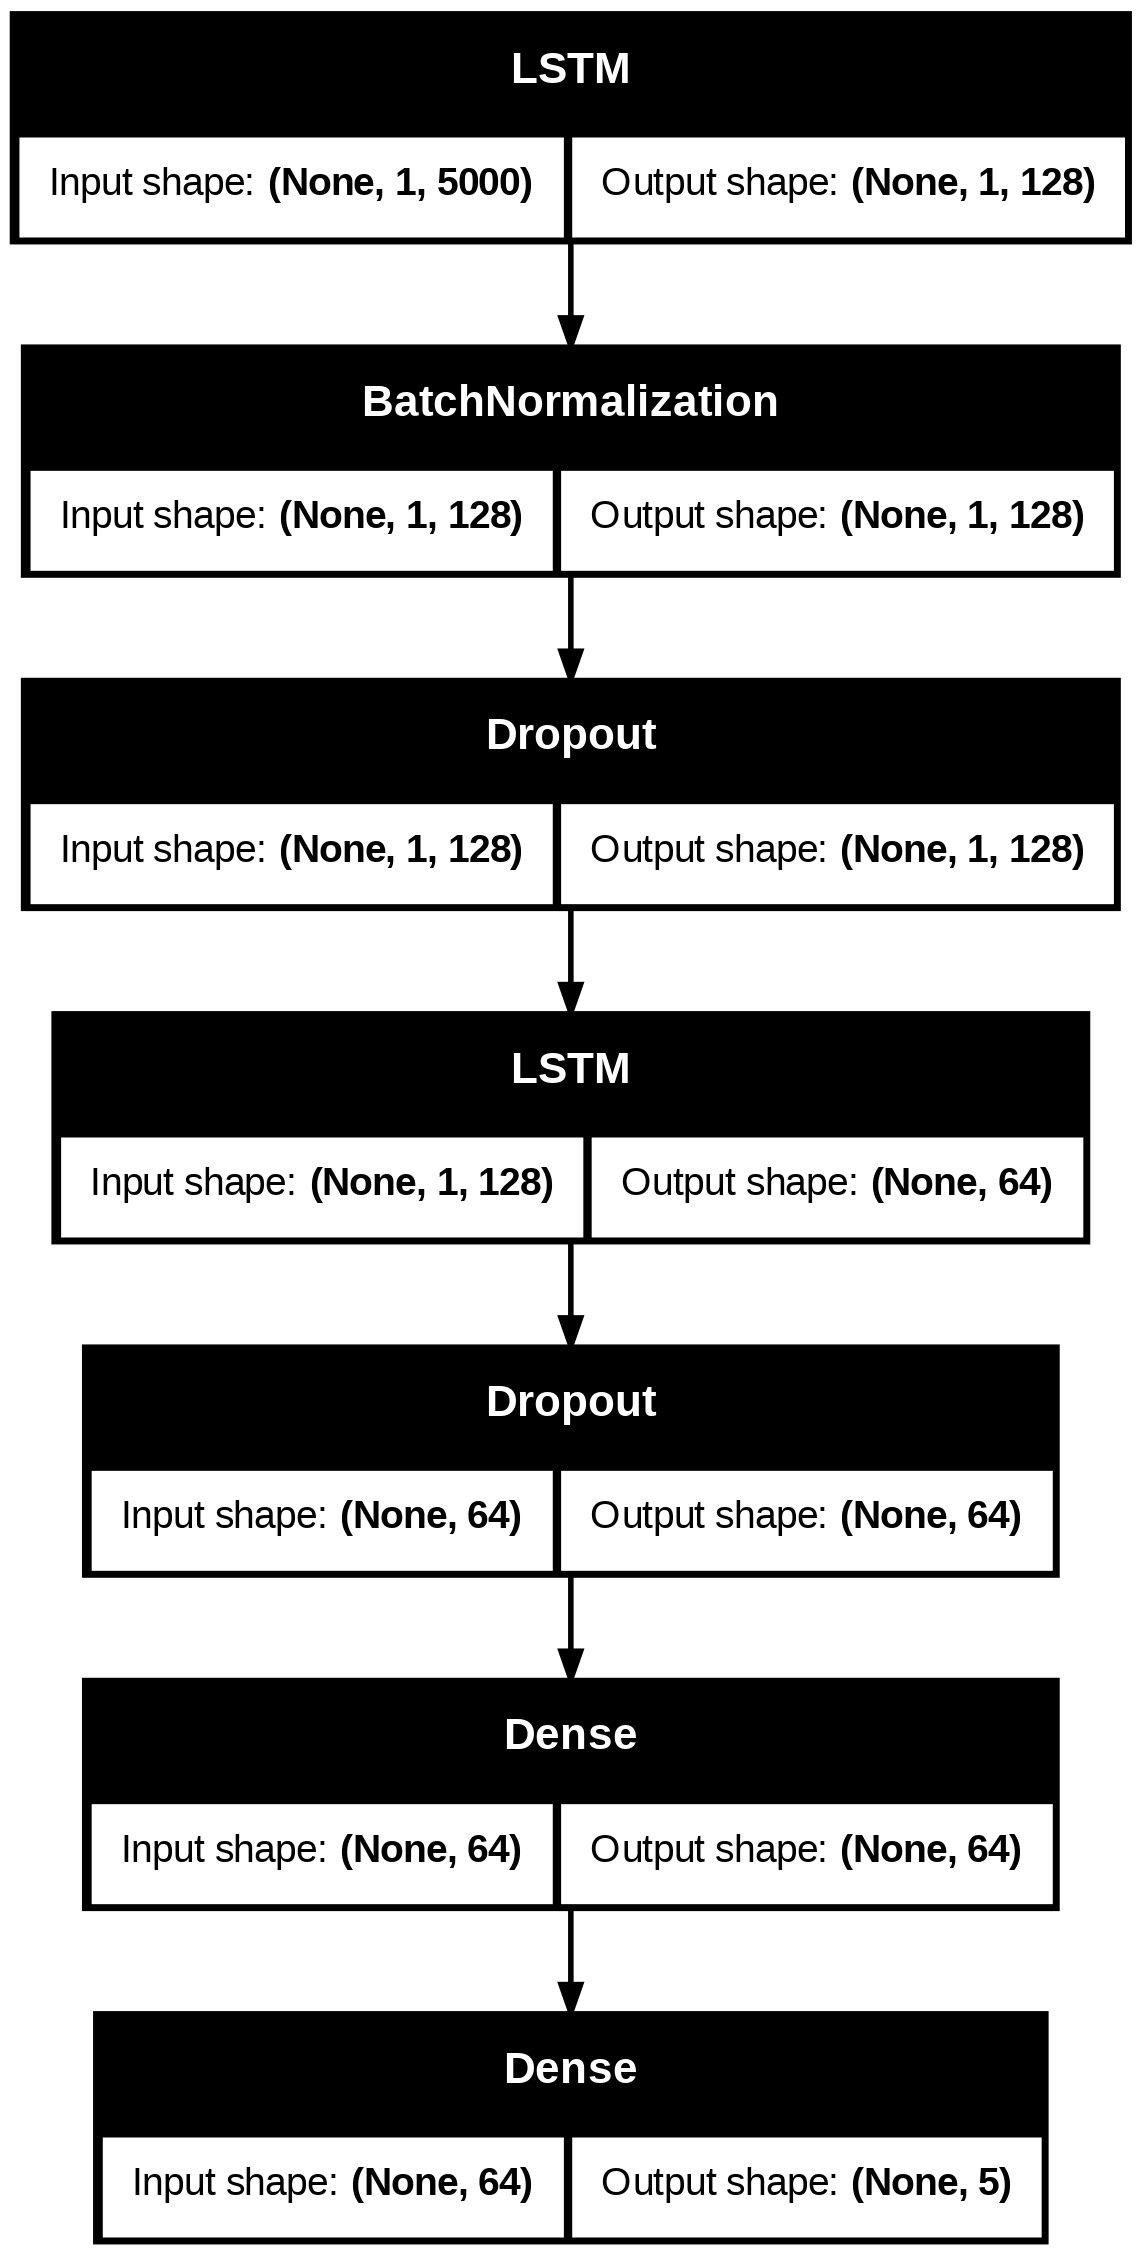

In [16]:
model_lstm.summary()
keras.utils.plot_model(model_lstm, show_shapes=True)

In [17]:
#testing
test_data = pd.read_csv("/content/drive/MyDrive/NN_Data/test.csv")
test_data['Discussion'] = test_data['Discussion'].apply(preprocess_text)
pred = tfidf_vectorizer.transform(test_data['Discussion']).toarray()

pred = pred.reshape(pred.shape[0], 1, pred.shape[1])
pred = model_lstm.predict(pred)
test_predictions = np.argmax(pred, axis=1)
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})
print(result.head(10))
result.to_csv('/content/drive/MyDrive/NN_Data/output.csv', index=False)

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3
5         6         0
6         7         1
7         8         3
8         9         0
9        10         3
